importing cleaned-up data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
data=pd.read_csv('newsplus.csv')
data.text=data.text.str.replace('reuters','') #in case we missed it before


Using scikit-learn to split into a training set and a test set. Using the default options of shuffling the data and dividing it into a 75% training/25% test split

In [2]:
from sklearn.model_selection import train_test_split
train,test= train_test_split(data)


Discarding most of the training data after finding that use of all of it meant using a lot of time and memory.

In [3]:
train2=train.sample(frac=.1)
X_train=train2.text
y_train=train2.fake

One more pass to eliminate non-string values from the text.

In [4]:
X_train['type'] = X_train.apply(lambda row: type(row))
y_train=y_train[X_train.type==str]
X_train['type'] = X_train.apply(lambda row: type(row)) #not sure but the following line wouldn't execute until I ran this again
X_train=X_train[X_train.type==str] 
#print(X.shape)
#print(y.shape)


<ipython-input-4-832e5abd3ea6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['type'] = X_train.apply(lambda row: type(row))


In [5]:
wordslist=[]
poslist=[]
import nltk
i=0
for w in X_train:
    token=nltk.word_tokenize(w)
    for thing in token:
        if thing==thing.lower():
            try:
                wordslist[i]=(wordslist[i]+' '+thing)
            except:
                wordslist.append(thing)
        else:
            try:
                poslist[i]=(poslist[i]+' '+thing)
            except:
                poslist.append(thing)
    i=i+1

In [6]:
df=pd.DataFrame(wordslist,columns=['words'])

In [7]:
df['pos']=poslist

In [8]:
df.head()

,words,pos
0,leaked email hillary clinton campaign manager ...,VBN NNS JJ NN NN NN NN VBP JJ NN NN VBN NNS VB...
1,berlin chancellor angela merkel piled pressure...,NN NN NN NN VBD NN NN JJ NNPS VBP VB JJ NN VBZ...
2,republican party fractured division deeper eve...,JJ NN VBD NNS IN RB NNS CD NN NN VBZ VBP NN NN...
3,donald trump team keep trying make public thin...,NN NN NN VBZ VBG VB JJ VB JJ JJ NN VBP JJ JJ N...
4,though still week christmas saturday night liv...,IN RB NN NN JJ NN VBP RB VBN NN VBP VBN NN VBG...


Converting into a vector of words (experiment showed that single words worked best when parts of speech weren't included).

In [9]:
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
vect1 = TfidfVectorizer(stop_words='english', max_features=40)
vect2=TfidfVectorizer(stop_words='english',max_features=20,ngram_range=(1,3))
vect1.fit(df.words)
vect2.fit(df.pos)

TfidfVectorizer(max_features=20, ngram_range=(1, 3), stop_words='english')

In [10]:
vect1.vocabulary_ 

{'hillary': 10,
 'clinton': 2,
 'campaign': 1,
 'washington': 34,
 'time': 29,
 'group': 9,
 'president': 23,
 'government': 8,
 'national': 16,
 'election': 6,
 'official': 20,
 'say': 27,
 'new': 17,
 'year': 39,
 'told': 30,
 'united': 32,
 'state': 28,
 'said': 26,
 'party': 21,
 'republican': 24,
 'donald': 5,
 'trump': 31,
 'news': 18,
 'white': 37,
 'house': 11,
 'way': 35,
 'like': 13,
 'people': 22,
 'make': 14,
 'want': 33,
 'week': 36,
 'american': 0,
 'woman': 38,
 'country': 3,
 'right': 25,
 'day': 4,
 'obama': 19,
 'medium': 15,
 'law': 12,
 'going': 7}

In [11]:
vect2.vocabulary_

{'vbn': 18,
 'nns': 12,
 'jj': 0,
 'nn': 5,
 'vbp': 19,
 'rb': 14,
 'vbd': 15,
 'vbg': 17,
 'jj nn': 2,
 'nn nn': 8,
 'nns vbp': 13,
 'nn nns': 10,
 'nn jj': 6,
 'jj nns': 4,
 'jj jj': 1,
 'nn vbd': 11,
 'vbd jj': 16,
 'jj nn nn': 3,
 'nn nn nn': 9,
 'nn jj nn': 7}

In [12]:
word_matrix_train = vect1.transform(df.words)

In [13]:
pos_matrix_train=vect2.transform(df.pos)

In [14]:
print(word_matrix_train.shape)
print(pos_matrix_train.shape)

(4874, 40)
(4874, 20)


In [15]:
import scipy
feature_matrix_train=scipy.sparse.hstack((word_matrix_train,pos_matrix_train))

In [16]:
feature_matrix_train.shape

(4874, 60)

In [17]:
y_train.shape #checking for compatibility

(4874,)

[t-SNE] Computing 73 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.016s...
[t-SNE] Computed neighbors for 1000 samples in 0.125s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.321823
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.728310
[t-SNE] KL divergence after 1000 iterations: 1.395002


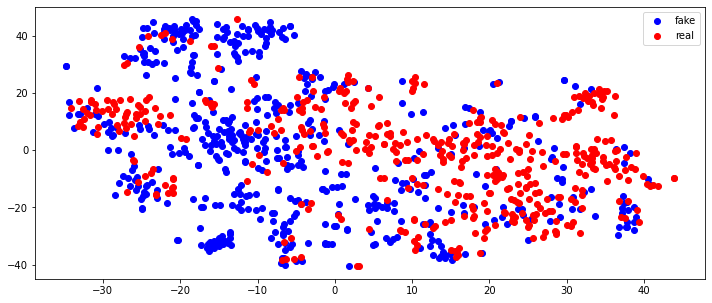

In [18]:
from sklearn.manifold import TSNE
matrix=feature_matrix_train.toarray()[:1000]
vector=y_train[:1000]
tsne_reduction=TSNE(n_components=2,perplexity=24,verbose=1) 
feature_matrix_reduced=tsne_reduction.fit_transform(matrix)
plt.figure(figsize=(12,5))
plt.plot(feature_matrix_reduced[vector==1,0],feature_matrix_reduced[vector==1,1],'bo',label='fake')
plt.plot(feature_matrix_reduced[vector==0,0],feature_matrix_reduced[vector==0,1],'ro',label='real')
plt.legend()

Fitting and testing a logistic regression model after transforming the test set to be conformable with the training set.

In [19]:
from sklearn.linear_model import LogisticRegression

In [20]:
log_clf = LogisticRegression(max_iter=1000)
log_clf.fit(feature_matrix_train,y_train)


LogisticRegression(max_iter=1000)

In [21]:
X_test=test.text
y_test=test.fake
X_test['type'] = X_test.apply(lambda row: type(row))
y_test=y_test[X_test.type==str]
X_test['type'] = X_test.apply(lambda row: type(row)) #not sure but the following line wouldn't execute until I ran this again
X_test=X_test[X_test.type==str] 
wordslist=[]
poslist=[]
import nltk
i=0
for w in X_test:
    token=nltk.word_tokenize(w)
    for thing in token:
        if thing==thing.lower():
            try:
                wordslist[i]=(wordslist[i]+' '+thing)
            except:
                wordslist.append(thing)
        else:
            try:
                poslist[i]=(poslist[i]+' '+thing)
            except:
                poslist.append(thing)
    i=i+1
tdf=pd.DataFrame(wordslist,columns=['words'])
tdf['pos']=poslist
word_matrix_test = vect1.transform(tdf.words)
pos_matrix_test=vect2.transform(tdf.pos)
feature_matrix_test=scipy.sparse.hstack((word_matrix_test,pos_matrix_test))
y_test_pred = log_clf.predict(feature_matrix_test)
from sklearn.metrics import confusion_matrix,accuracy_score
confusion_matrix(y_test,y_test_pred)

<ipython-input-21-60f928505afa>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['type'] = X_test.apply(lambda row: type(row))
C:\Users\User\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\User\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3343: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, sel

array([[6401, 1578],
       [1324, 6941]], dtype=int64)

In [22]:
accuracy_score(y_test,y_test_pred)

0.8213494213247968

In [23]:
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import GridSearchCV
parameters={'alpha':[0,.01,.1,1]}
RCbasic=RidgeClassifier(max_iter=1000, solver='sparse_cg')
RC=GridSearchCV(RCbasic,parameters)
RC.fit(feature_matrix_train,y_train)
RC.best_params_

{'alpha': 0.1}

In [24]:
y_test_pred = RC.best_estimator_.predict(feature_matrix_test)
confusion_matrix(y_test,y_test_pred)

array([[6363, 1616],
       [1311, 6954]], dtype=int64)

In [25]:
accuracy_score(y_test,y_test_pred)

0.81981039152918

In [26]:
from sklearn.tree import DecisionTreeClassifier
DT=DecisionTreeClassifier(criterion='entropy')
parameters={'max_depth':[2,3,4,6,None],'max_features':['auto','log2',None]}
DT2=GridSearchCV(DT,parameters)
DT2.fit(feature_matrix_train,y_train)


GridSearchCV(estimator=DecisionTreeClassifier(criterion='entropy'),
             param_grid={'max_depth': [2, 3, 4, 6, None],
                         'max_features': ['auto', 'log2', None]})

In [27]:
DT2.best_params_

{'max_depth': 6, 'max_features': None}

In [28]:
y_test_pred=DT2.best_estimator_.predict(feature_matrix_test)
confusion_matrix(y_test,y_test_pred)

array([[6130, 1849],
       [1510, 6755]], dtype=int64)

In [29]:
accuracy_score(y_test,y_test_pred)

0.7932159566609209

In [30]:
from sklearn.naive_bayes import MultinomialNB

In [31]:
NBbasic=MultinomialNB() 
parameters={'alpha':[.001,.01,.1,1]}
NB=GridSearchCV(NBbasic,parameters)
NB.fit(feature_matrix_train,y_train)
NB.best_params_

{'alpha': 1}

In [32]:
y_test_pred=NB.best_estimator_.predict(feature_matrix_test) 
confusion_matrix(y_test,y_test_pred)

array([[6099, 1880],
       [1701, 6564]], dtype=int64)

In [33]:
accuracy_score(y_test,y_test_pred)

0.7795493720758434

Had to reduce the dimensionality from the 100-feature matrix we had to avoid getting memory overflows when doing a k-nn
classification.

In [34]:
from sklearn.neighbors import KNeighborsClassifier
parameters={'n_neighbors':[4,10,15],'weights':['distance','uniform']}
knnbegin=KNeighborsClassifier() #selected for n_neighbors and weights via grid search
from sklearn.decomposition import TruncatedSVD
flat=TruncatedSVD(n_components=10) #still getting memory errors with 100 features
flat.fit(feature_matrix_train)


TruncatedSVD(n_components=10)

In [35]:
ftrain=flat.transform(feature_matrix_train)

knn.fit(ftrain,y_train) #nothing to fit I guess but this seems to work as intended

In [36]:
knn=GridSearchCV(knnbegin,parameters)
knn.fit(ftrain,y_train)
knn.best_params_

{'n_neighbors': 15, 'weights': 'distance'}

In [37]:
ftest=flat.transform(feature_matrix_test)

In [38]:
y_test_pred=knn.best_estimator_.predict(ftest)
confusion_matrix(y_test,y_test_pred)


array([[6181, 1798],
       [1288, 6977]], dtype=int64)

In [39]:
accuracy_score(y_test,y_test_pred)

0.8100221620290569

Unable to test with cosine similarity even on much smaller dataset due to memory errors

In [40]:
knn2=KNeighborsClassifier(metric='cosine')
parameters={'n_neighbors':[4,10,15]}

In [41]:
knn3=GridSearchCV(knn2,parameters)
knn3.fit(ftrain,y_train)

GridSearchCV(estimator=KNeighborsClassifier(metric='cosine'),
             param_grid={'n_neighbors': [4, 10, 15]})

In [42]:
knn3.best_params_

{'n_neighbors': 15}

Gradient boosting classifier is a newer classification method with a good track record. In the basic version seen here it builds a number of decision trees (100 is the default; more trees usually result in better predictions since the model is considered fairly robust to overfitting). Ultimately it returns an average of all the trees that are built weighted by the 
accuracy of each one. However, unlike in a random forest, each tree that is built after the first one is fitted to the residual 
of the weighted predictions so far, so that each new tree that is built corrects for the errors from the previous model.

In [43]:
from sklearn.ensemble import GradientBoostingClassifier
GTB_clf = GradientBoostingClassifier()

Parameters that can profitably tuned include the depth of the trees and the maximum number of features to be 
considered when looking for the best split in each tree.

In [44]:
parameters={'max_features':('auto','log2',None), 'max_depth':[2,3,4,6,None]}
GTB=GridSearchCV(GTB_clf,parameters)
GTB.fit(feature_matrix_train,y_train)

GridSearchCV(estimator=GradientBoostingClassifier(),
             param_grid={'max_depth': [2, 3, 4, 6, None],
                         'max_features': ('auto', 'log2', None)})

In [45]:
GTB.best_params_

{'max_depth': 6, 'max_features': 'log2'}

In [46]:
y_test_pred=GTB.best_estimator_.predict(feature_matrix_test)
confusion_matrix(y_test,y_test_pred)

array([[6588, 1391],
       [1156, 7109]], dtype=int64)

In [47]:
accuracy_score(y_test,y_test_pred)

0.843203644422556

A function to transform raw text in identical fashion to the transformations used on the text in our training data, and to test
each of the classification algorithms on a given text.

In [48]:
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
stop=stopwords.words('english')
import re
def tokenizeandstopwords(text):
    tokens = nltk.word_tokenize(text)
    # taken only words (not punctuation)
    token_words = [w for w in tokens if w.isalpha()]
    meaningful_words = [w for w in token_words if not w in stop]
    joined_words = ( " ".join(meaningful_words))
    parts_speech = [nltk.pos_tag(meaningful_words)][0]
    speech_list = [d[1] for d in parts_speech]
    joined_pos=(" ".join(speech_list))
    return joined_words,joined_pos
def clean(text):
    data=text.split('Featured image')[0]
    data=data.split('Photo by')[0]
    data=data.split('connect Facebook')[0]
    data=data.split('Follow Twitter')[0]
    data=data.split('Follow him on Twitter')[0]
    data=data.split('Follow her on Twitter')[0]
    return data.split('Click buy')[0]
    return data.split('Click buy')[0]
def basic_clean(text):
  """
  A simple function to clean up the data. All the words that
  are not designated as a stop word is then lemmatized after
  encoding and basic regex parsing are performed.
  """
  wnl = nltk.stem.WordNetLemmatizer()
  stopwords = nltk.corpus.stopwords.words('english')
  words = re.sub(r'[^\w\s]', '', text).split()
  return [wnl.lemmatize(word) for word in words if word not in stopwords]
def testrawtext(text):
    text=clean(text)
    text = re.sub("http://\S+"," ", text)
    text = re.sub("\@", " ",text.lower())
    text= text.replace('reuters','')
    text1,text2=tokenizeandstopwords(text)
    data1=basic_clean(text1)
    text1=' '.join(word for word in data1)
    tsxt1=[]
    tsxt2=[]
    tsxt1.append(text1)
    tsxt2.append(text2)
    txt1=pd.Series(data=tsxt1)
    txt2=pd.Series(data=tsxt2)
    mat1=vect1.transform(txt1)
    mat2=vect2.transform(txt2)
    mat=scipy.sparse.hstack((mat1,mat2))
    fat=flat.transform(mat)
    print ('logistic classifier',log_clf.predict(mat)==0)
    print ('ridge classifier',RC.best_estimator_.predict(mat)==0)
    print ('decision tree',DT2.best_estimator_.predict(mat)==0)
    print ('naive Bayes',NB.best_estimator_.predict(mat)==0)
    print ('knn: Euclidean',knn.best_estimator_.predict(fat)==0)
    print ('knn: cosine', knn3.best_estimator_.predict(fat)==0)
    print ('gradient boosting classifier',GTB.best_estimator_.predict(mat)==0)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Test texts pertaining to the 2020 election cycle and Covid-19 epidemic were haphazardly selected from the Internet from general-
interest newspapers with free online access. 4 real news sites and 1 fake news site were included.

In [49]:
missoulian='''U.S. Rep. Greg Gianforte on Wednesday threaded the needle on face mask mandates put in place to reduce the spread of COVID-19.

The gubernatorial candidate and his running mate, Kristen Juras, were stumping at the Missoula GOP field office Wednesday morning before a crowd of about 20, nearly all wearing masks except for the candidates.

During a question-and-answer session with voters, one man asked how an unelected official — in this case a public health officer — can order people to wear a mask. The question resonated in a county where businesses have faced backlash for enforcing Missoula County's mandate, and came hours before Gov. Steve Bullock issued a statewide order to wear masks in certain settings. Indeed, Gianforte has had his own close call with the coronavirus after the girlfriend of Donald Trump Jr. tested positive for COVID-19 several days after she and Trump Jr. attended a campaign event at Big Sky. Gianforte wasn't at the event, but self-quarantined anyway because both his wife Susan and Juras were there.


"In emergency situations, there are authorities delegated to local authorities," Gianforte told the man. "Let me tell you where I am: I don't want to second-guess the decisions that were made up until this point. But based on the input I have, I think, going forward, as a policy perspective as your next governor, we need to focus on keeping the most vulnerable safe, personal responsibility, not government mandates."

After the event, Gianforte told the Missoulian he believes masks do "have a role," and did not decry local governments for issuing their own orders, but again said personal responsibility should be emphasized.

"I trust local government to make decisions that are right for their communities," he said. 

Gianforte and Juras were in Missoula on the second day of their campaign tour touting their "Montana Comeback Plan," an economic plan to return the state to economic stability following record unemployment and a cratered business landscape, both induced by the coronavirus pandemic. It also serves as a blueprint for focusing efforts on higher wages, manufacturing jobs and value-added agriculture so Montanans do not leave the state in search of good pay, he said. 

"We've got to get our economy back open up again," he said. "We have to keep people safe, but that's Step One. The remainder of the plan is, how do we build on that. … As we bring manufacturing jobs back from China, I want Montana to get its share of those jobs."Gianforte did not mention Trump by name throughout his speech on Wednesday, at least not until he took a question from another member of the crowd, Michael Priske. Priske was testy with the congressman for not answering his previously emailed questions in kind but with "form letters." So Priske brought with him to the event a legal pad with his questions: Why did Gianforte not back the president on the Russian collusion claims? Why hasn't he taken a stand against the destruction of historic monuments? Why hasn't the congressman pushed back against defunding the police?

"What are you doing to address these issues, which are way bigger than trying to get Montana back to work?" Priske said. "Me and my wife are so disturbed about what's going on in Missoula right now, we think we are going to sell everything that we own and move to New Zealand."

Gianforte told Priske his office takes about 5,000 inquiries a week, and said he wishes he could respond to each one. But Gianforte pushed back against the idea that he didn't stand with Trump.

"Let me be very clear, I stand with President Trump," he said. "I’ve voted with him over 90% of the time in Congress. I agree with you that we need to stand with our police, this idea of defunding the police is a ridiculous idea. We are a country that relies on the rule of law."'''

In [50]:
testrawtext(missoulian)

logistic classifier [ True]
ridge classifier [ True]
decision tree [ True]
naive Bayes [ True]
knn: Euclidean [ True]
knn: cosine [ True]
gradient boosting classifier [ True]


In [51]:
fox='''Team Biden said it expects President Trump to “lie through his teeth” at the first presidential debate between the two nominees -- while downplaying the significance it could have on the race as Trump and Democratic nominee Joe Biden face off for the first time next week.


“Fox News Sunday” anchor Chris Wallace has been selected to moderate the first presidential debate between Trump and Biden, the nonpartisan Commission on Presidential Debates (CPD) announced earlier this month.The debate is scheduled to take place Tuesday, Sept. 29 in Cleveland, Ohio.

A source familiar with the former vice president’s campaign told Fox News that they expect Trump will be “extremely practiced” and “prepared” to debate Biden. But the source that “there is no debate performance that can fundamentally shift the race because of what people are living through,” referring to the coronavirus pandemic.

“Everyone is stuck in a reality on account of Trump’s mismanagement, so there is no outcome during the debate that can really change the trajectory of this race,” the source told Fox News. “If Trump has a good debate, which we anticipate, and he has no compunctions about lying through his teeth and making things up on the spot, American life is still defined by his failure to have any plan to beat COVID.”

The source added: “We know Donald Trump is going to lie through his teeth, but Joe Biden’s goal is to share his agenda, his plan and his values."

A former Biden staffer also told Fox News that "everybody knows" the president now, and said that people are "fully aware of how he operates and that he likes to lob insults and bait people by stating things that are not true.""If you make that the fact that he lies all the time the issue, that’s less compelling than talking about how his lies have caused harm to the country," the staffer told Fox News. "[Biden] needs to make Trump’s behavior relevant to voters. It has to be grounded in something that matters.”

But Jay Carney, former White House press secretary for President Obama and former communications director for Biden as vice president, told Fox News that the debate itself could be a "challenge."

“I know Vice President Biden sees this as a serious challenge," Carney told Fox News. "President Trump has an advantage in that he is an expert at delivering memorable sound bites and engaging in short-form scrums."

Carney added that Trump "gets in regular practice with all his short encounters with the press, and that kind of format, ironically, is close enough to what you experience in a debate that I doubt he’ll be rusty.”

Carney said, however, that he thinks Biden "will come in with a plan and will execute on it."

"And then we’ll have to see how successful the president is in disrupting it," Carney said.

The early months of Biden’s third White House bid were marked by uneven debate performances and winding town halls in Iowa and New Hampshire. The floundering led to numerous stories about Biden’s gaffes and near-constant attacks from Trump about Biden’s mental fitness.


Since then, however, the former vice president has drawn praise for both his performance against Sanders in March and, more recently, for his speech at last month’s Democratic National Convention.

When asked whether the campaign was concerned about a debate night gaffe from the former vice president, the source defended Biden, saying that “the American people know this about him.”

“In fact, it makes him more relatable to them,” the source said, while adding that the campaign “does not see the debate as a very big inflection point in the race.”

"We see that as something only the media cares about but that voters don’t," the source added.

And former communications director for Pete Buttigieg’s presidential campaign, Lis Smith, shared a similar sentiment, saying that his gaffe-making is “part of his appeal.”

“He comes across as a genuine, regular guy, and not like an overly programmed politician,” Smith said. “The narrative as Biden as a gaffe machine overlooks the reality that Joe Biden’s brand is being good ol’ regular Joe, Uncle Joe, and sometimes the things he says don’t come out quite right, but that’s part of his appeal as a politician.”

She added: “Some people underestimate how baked in the cake some of this is about Joe Biden and how the fact that he isn’t a slick-talking, points-oriented politician works to his benefit. Most people don’t speak in perfect prose.”But Trump has seized on Biden’s gaffes along the campaign trail, questioning whether the former vice president was taking medication to enhance his primary debate performances — a topic he has raised repeatedly in the past several weeks, while calling for a mandatory drug test ahead of the general election debates.

Trump offered no evidence to support his claims nor did he say what drug he thought Biden was taking.

The president, during an exclusive interview with “Fox & Friends” Monday, though, said he thinks Biden is “a professional.”

“I don’t know if he’s all there, but I think he’s a professional,” Trump said. “I have to assume that he is a professional and that he can debate.”As for his strategy should Trump lob personal attacks at the former vice president, the source told Fox News that Biden “will certainly stand up for himself and for American families.”

But others familiar with Biden’s debate style suggested that he would rise above any insults, or personal attacks, by responding with arguments rooted in policy shortfalls of the Trump administration.

“What was interesting watching the primary debates was that Biden did not engage when his primary opponents attacked him,” Smith told Fox News. “He was usually one of the big targets, and did face a number of nasty, fairly personal, attacks, but what I saw, and what we all saw, was that he sort of just brushed them off, laughed them off and kept going back to his own message rather than going down the rabbit hole of responding.”

She added: “That’s going to be a really critical skill against Trump.”

Smith said she anticipates the president will “do everything in his power” to get Biden “off message and in the mud with him.”

“I just think history has shown that if you get down in the mud with Donald Trump, you probably won’t come out a winner of that one,” Smith said. “And that sort of discipline is going to be really important.”

Carney also told Fox News he thinks Biden "will stick to his plan and avoid getting into an insult competition."

"I think he’ll immediately go to the issues that people care about and keep returning to them," Carney said. "You can certainly point out your opponent’s failings in the context of the issues that people care about, like health care, the coronavirus response, the economic welfare of the nation in a very precarious moment."

He added: "There are ways to do that but not make it personal – where Biden can make the case, for example, that the president’s response to COVID-19 has been a failure and that he would do a better job. He can do that on a lot of issues. He can make the contrast without getting into name-calling.”

placeholder
Meanwhile, as Team Biden is downplaying the debate’s impact in general, Team Trump is ramping up expectations, after months of undermining Biden’s abilities to take on the president.

“Joe Biden has been a Washington politician for 47 years, he spent decades in the Senate where all they do is debate, he was vice president twice, and debated on the national stage in each of those races, and did very well,” Trump campaign Communications Director Tim Murtaugh said in an interview with Fox News Monday.

“In the Democrat primaries, he debated a whole crowd of opponents, 11 times, and he won,” he continued. “He bested two dozen Democrat challengers.”

Murtaugh added that Biden “knows his way around the debate stage.

“He knows how to do it,” he said. “He’s actually quite good. That’s the Joe Biden we expect to see on debate night.”

Murtaugh added: “We have to be prepared for the tuned-in Joe Biden.”

Nevertheless, those in Biden’s camp are maintaining that the debate will have little influence on the race in general.

placeholder
“[Debates] used to have that potential to change things, but what seems to be true more and more is that they don’t have a significant impact on the race," Carney told Fox News, while adding that the race "has been static, in Vice President Biden’s favor, for a long time, which means the president needs to find a way to disrupt the trajectory of the race."

"The debates give him an opportunity to do that," he said.

“I think everyone is trying to build up the debate as a potential game-changer in this contest, but the story of 2020 has been a story of remarkable stability,” Smith added. “And if a global pandemic can’t fundamentally shift the dynamics of the race, I doubt the debate will.”'''

In [52]:
testrawtext(fox)

logistic classifier [ True]
ridge classifier [ True]
decision tree [ True]
naive Bayes [False]
knn: Euclidean [ True]
knn: cosine [ True]
gradient boosting classifier [ True]


In [53]:
latimes='''President Trump refused Wednesday to commit to giving up power should he lose the November race, adding to concerns that a contested election could lead to a constitutional crisis and a unique challenge to the nation’s democracy.
Trailing the Democratic nominee, Joe Biden, in national and swing state polls six weeks before Election Day, Trump again presented invented claims of voter fraud as a pretext for his campaign’s all but certain legal challenges and, for the first time, his possible refusal to vacate the Oval Office should he lose.

When a reporter noted the already combustible American landscape and asked Trump if he would “commit here today for a peaceful transfer of all power after the election,” the president declined to do so.

“We’re going to have to see what happens,” he said. “You know that I’ve been complaining very strongly about the ballots, and the ballots are a disaster.”“We want to get rid of the ballots and you’ll have a very peaceful — there won’t be a transfer, frankly. There will be a continuation,” he added, suggesting that he would only view an election that he wins as legitimate.

Biden offered sarcasm but did not evince deep concern when he was asked about Trump’s statement.

“What country are we in?,” he said in Wilmington, Del., after a day of campaigning. “Look, he says the most irrational things. I don’t know what to say.”Andrew Bates, a campaign spokesman, cited Biden’s statement on July 19. “The American people will decide this election,” he said at the time. “And the United States government is perfectly capable of escorting trespassers out of the White House.”

Trump’s declaration that “there won’t be a transfer” alarmed election experts, even those inured to his penchant for falsehoods and controversy.

“In case anyone is unclear on the concept, in the United States of America, we do not ‘get rid of’ ballots. We count them,” said Ellen L. Weintraub, a commissioner on the Federal Elections Commission. “Counting the ballots— all the ballots — is the way we determine who leads our country after our elections. The only way.”

Republicans were largely silent. But Sen. Mitt Romney (R-Utah), the party’s 2012 presidential nominee and a sometimes critic of Trump, condemned his refusal to commit to leaving office if he loses.“Fundamental to democracy is the peaceful transition of power; without that, there is Belarus,” Romney tweeted. “Any suggestion that a president might not respect this Constitutional guarantee is both unthinkable and unacceptable.”

The president’s warnings of lawsuits and de-legitimizing of the voting process has added uncertainty to a country already convulsed by a pandemic, recession, racial strife and climate disasters.

“There’s an economic angle here, too,” Justin Wolfers, an economist at the University of Michigan, tweeted. “The legitimacy and stability of democratic institutions and the rule of law are critical to investment and to our long run economic health.”

The president’s comments came hours after he suggested that he would push forward with filling a vacancy on the Supreme Court because it might be called upon to resolve a disputed election.

Trump plans to nominate a conservative justice on Saturday to succeed liberal Ruth Bader Ginsburg, who died Friday, on the high court. The Republican-led Senate is expected to hold confirmation hearings in mid-October, and may hold a floor vote before Election Day.

If confirmed, Trump’s pick would ensure a 6-3 conservative majority on the court, including three justices nominated by Trump.

“I think this will end up in the Supreme Court,” Trump said. “And I think it’s very important that we have nine justices.”


'''

In [54]:
testrawtext(latimes)

logistic classifier [ True]
ridge classifier [ True]
decision tree [ True]
naive Bayes [ True]
knn: Euclidean [ True]
knn: cosine [ True]
gradient boosting classifier [ True]


In [55]:
usatoday='''A New York judge ordered Eric Trump to sit for a deposition with state investigators before Oct. 7, denying his attempt to push it off until after Election Day.

New York Supreme Court Justice Arthur Engoron of Manhattan issued an oral ruling Wednesday siding with state Attorney General Letitia James' office, which sued Trump over his request to delay his deposition into November or beyond.

James' office is investigating whether President Donald Trump and his companies improperly inflated the value of four of his properties, including the massive Seven Springs estate in northern Westchester County.

The investigation is focused on whether the Trump Organization — which Eric Trump, the president's son, now leads — and the president benefitted financially from the potentially inflated values by getting better terms on loans and boosting tax write-offs.

In an online hearing Tuesday, Alan Futerfas, an attorney for Eric Trump, said his client's seven-days-a-week campaign schedule will not allow enough time for him to prepare for a deposition in the case.

Engoron was not convinced, calling Eric Trump's argument "unpersuasive" and ordering him to comply with the attorney general's deposition subpoena prior to Oct. 7.


"The court is not bound by the timeline of this election," Engoron said.

Engoron said he would sign his order later Wednesday.

James' ongoing investigation was launched after former Trump Organization attorney Michael Cohen accused Trump of inflating his assets. Cohen laid out his accusations during testimony to Congress in March 2019.

According to court filings, the probe focuses on four major Trump properties, including the 212-acre Seven Springs estate in northern Westchester. Donald Trump had been trying to develop for years before agreeing to a conservation easement in 2015, prior to becoming president.

The court documents from August show James' office is examining whether the Trump inflated the assessed value of the sprawling Westchester property, allowing one of his limited liability companies to claim a $21.1 million tax exemption on forms submitted to the IRS.




'''

In [56]:
testrawtext(usatoday)

logistic classifier [ True]
ridge classifier [ True]
decision tree [ True]
naive Bayes [False]
knn: Euclidean [ True]
knn: cosine [ True]
gradient boosting classifier [ True]


In [57]:
onion='As the Democratic presidential nominee ramped up his in-person efforts to get out the vote, members of the Joe Biden campaign reportedly went door-to-door Tuesday in the JPMorgan Chase headquarters. “Door-knocking is a core part of talking to supporters and getting our message out there, which is why we’re spending the day knocking on each and every office door in the entire building,” said Biden deputy campaign manager Pete Kavanaugh, adding that hundreds of volunteers were reaching out to every wealth manager, data analyst, and investment associate at the 383 Madison building to seek support and donations for the Democratic nominee before canvassing at the headquarters of Goldman Sachs and Morgan Stanley. “We explain to every potential supporter what a great candidate Biden is and how his vision for the country will make their lives better. We hope to get a commitment to vote, of course, but a little donation doesn’t hurt either. Polls show that the 12th floor is a tossup so we’re definitely focusing on that. A lot of these people were Hillary [Clinton] supporters in 2016, but we’re not taking anything for granted, and the Wall Street demographic represents our key supporters.” At press time, several members of the Biden campaign team expressed disappointment after speaking with several bankers who said they didn’t really see a difference between the two candidates.'

In [58]:
testrawtext(onion)

logistic classifier [False]
ridge classifier [False]
decision tree [ True]
naive Bayes [False]
knn: Euclidean [False]
knn: cosine [False]
gradient boosting classifier [False]


# Summary of results using raw word count vectorization

| Algorithm| Test set words/p.o.s./combo| Raw examples words/p.o.s./combo |
| --- | --- | --- |
| Logistic classifier | 81.6/71.9/80.8 | 100/80/100 |
| Ridge classifier | 79.4/70.6/78.2 | 100/100/100 |
| Decision Tree | 77.8/70.1/78.5 | 40/60/100 |
| Naive Bayes | 79.8/70.3/79.6 | 80/80/80 |
| knn-Euclidean | 82.3/72.8/72.9 | 80/80/80 |
| knn-cosine | 82.2*/71.3*/NA | 80/40/80 |
| Gradient Boosting | 85.7/76.0/85.4 | 100/80/100 |

*These results were on a considerably reduced dataset

|Algorithm/hyperparameter| Best parameters for words/p.o.s./combo|
| --- | --- |
|Ridge classifier/L2 regularization term| 1/1/.1|
|Decision Tree/max depth| 6/6/3|
|Decision Tree/max features| None/None/None|
|Naive Bayes/smoothing parameter|  .001/.001/.001|
|k-nn Euclidean/neighbors| 15/15/15|
|k-nn Euclidean/weights| distance/distance/distance|
|k-nn cosine/neighbors| 15/15/15|
|boosting/max depth| 6/6/4|
|boosting/max features| sqrt/sqrt/None|

|news source| total correctly classified using words/p.o.s/combo*|
| --- | --- |
|Missoulian (real)|7/6/7 (20/21 total)|
|Fox (real)|5/2/5 (12/21 total)|
|LA Times (real)|6/7/7 (20/21 total)|
|USA Today (real)|6/6/7 (19/21 total)|
|Onion (fake)|5/5/6 (16/21 total)|

*maximum of 7 correctly classified for each prediction matrix type

# Summary of results using TF-IDF vectorization

| Algorithm| Test set words/p.o.s./combo| Raw examples words/p.o.s./combo |
| --- | --- | --- |
| Logistic classifier | 83.6/73.8/82.1 | 100/80/100 |
| Ridge classifier | 83.5/74.3/82.0 | 100/80/100 |
| Decision Tree | 78.7/69.4/79.3 | 40/80/80 |
| Naive Bayes | 78.9/66.9/78.0 | 80/60/60 |
| knn-Euclidean | 82.4/71.2/81.0 | 80/60/100 |
| knn-cosine | 82.4*/71.0*/NA | 80/60/100 |
| Gradient Boosting | 85.6/74.7/84.3 | 100/60/100 |

*These results were on a considerably reduced dataset

|Algorithm/hyperparameter| Best parameters for words/p.o.s./combo|
| --- | --- |
|Ridge classifier/L2 regularization term| 1/1/.1|
|Decision Tree/max depth| 6/4/6|
|Decision Tree/max features| None/None/None|
|Naive Bayes/smoothing parameter|  1/.001/1|
|k-nn Euclidean/neighbors| 15/15/15|
|k-nn Euclidean/weights| distance/distance/distance|
|k-nn cosine/neighbors| 15/15/15|
|boosting/max depth| None/None/6|
|boosting/max features| log2/log2/log2|

|news source| total correctly classified using words/p.o.s/combo*|
| --- | --- |
|Missoulian (real)|7/5/7 (19/21 total)|
|Fox (real)|3/1/6 (10/21 total)|
|LA Times (real)|6/7/7 (20/21 total)|
|USA Today (real)|7/5/6 (18/21 total)|
|Onion (fake)|6/6/6 (18/21 total)|

*maximum of 7 correctly classified for each prediction matrix type

In [2]:
#Observe that while using TF-IDF vectorization instead of raw word count vectorization generally impaired performance when using
#parts of speech only and when using Naive Bayes or gradient boosting algorithms, it generally improved performance with
#other algorithms when using words either by themselves or in combination with parts of speech to build the prediction matrices.
#The most striking improvement came with the k-nn model when using both words and parts of speech as predictive elements. On the
#examples from the newspapers, TF-IDF generally performed worse at correctly classifying real news, although it more accurately
#classified the Onion article as fake news. The best hyperparameters were meaningfully different for the TF-IDF from the raw
#word count vectorization for just those algorithms for which the TF-IDF vectorization underperformed.